In [1]:
import torch, torchvision
torch.cuda.get_device_name(0)

'NVIDIA RTX A6000'

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 0 to use
torch.cuda.current_device()

0

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

# 기존 코드와 동일한 부분
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")

EPOCHS = 100
BATCH_SIZE = 64

# CIFAR-10 데이터셋을 불러옴
trainset = datasets.CIFAR10(
    root='./.data/',
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
)
testset = datasets.CIFAR10(
    root='./.data/',
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        
    ])
)

train_loader = torch.utils.data.DataLoader(
    dataset=trainset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    dataset=testset,
    batch_size=BATCH_SIZE,
    shuffle=True,
)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(128 * 8 * 8, 512) # 이미지 크기 32x32
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x
        

model = CNN().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01)

# 훈련 및 테스트 손실을 저장할 리스트 생성
train_losses = []
test_losses = []

# train 및 evaluate 함수는 그대로 사용
def train(model, train_loader, optimizer):
    running_loss = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
            
        
        
        running_loss += loss.item() * data.size(0)
    return running_loss

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            
            # 배치 오차를 합산
            test_loss += F.cross_entropy(output, target, reduction='sum').item()
            
            # 가장 높은 값을 가진 인덱스가 바로 예측값
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

# Loss curve를 그리기 위한 리스트 생성
train_losses = []
test_losses = []

# 에폭(epoch)별로 학습 및 테스트 수행
best_acc = 0
best_loss = 1e9
best_epoch = 0

for epoch in range(1, EPOCHS + 1):
    running_loss = train(model, train_loader, optimizer)
    epoch_loss = running_loss / len(train_loader.dataset)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    # 훈련 및 테스트 손실 기록
    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    
    if test_loss < best_loss:
        best_loss = test_loss
        best_epoch = epoch
        best_acc = test_accuracy
    
    print('[{}] Test Loss: {:.4f}, Accuracy: {:.2f}%'.format(epoch, test_loss, test_accuracy))

Files already downloaded and verified
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.317152
Train Epoch: 1 [12800/50000 (26%)]	Loss: 2.172853
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.910324
Train Epoch: 1 [38400/50000 (77%)]	Loss: 2.063393
[1] Test Loss: 1.7976, Accuracy: 37.62%
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.925740
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.844645
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.988263
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.628276
[2] Test Loss: 1.5612, Accuracy: 44.19%
Train Epoch: 3 [0/50000 (0%)]	Loss: 1.565362
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.723038
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.540749
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.433061
[3] Test Loss: 1.4558, Accuracy: 48.10%
Train Epoch: 4 [0/50000 (0%)]	Loss: 1.579884
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.581318
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.393047
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.542700
[4] Test Loss: 1.3700, A

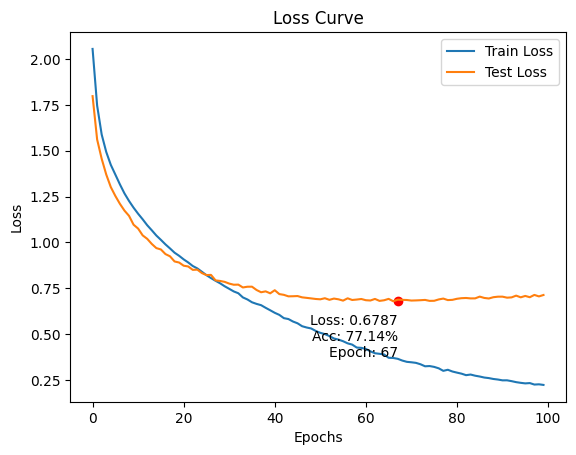

In [8]:

# Loss curve를 그림
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Loss가 가장 작은 지점에 빨간 점을 찍고 주석을 추가
plt.scatter(best_epoch, best_loss, color='red', marker='o')
plt.annotate(f'Loss: {best_loss:.4f}\nAcc: {best_acc:.2f}%\nEpoch: {best_epoch}', (best_epoch, best_loss), textcoords="offset points", xytext=(0, -40), ha='right')

plt.savefig('./plot/cnn_loss_curve.png')

In [9]:
torch.save(model.state_dict(), './save_weights/cnn.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('conv1.weight', tensor([[[[ 0.1528, -0.0891, -0.2618],
          [ 0.2778,  0.0037,  0.0273],
          [-0.1185,  0.1311,  0.1446]],

         [[ 0.0823, -0.3784, -0.3168],
          [ 0.2085,  0.1007,  0.1820],
          [ 0.1452,  0.1384,  0.0637]],

         [[-0.2297, -0.3394, -0.3770],
          [ 0.1679,  0.2038,  0.1473],
          [ 0.2101,  0.1390, -0.1495]]],


        [[[-0.2914,  0.1992,  0.1405],
          [-0.0092, -0.4861,  0.2254],
          [ 0.3148, -0.2420, -0.1122]],

         [[-0.3802,  0.4554,  0.3152],
          [ 0.1542, -0.1817,  0.5403],
          [ 0.4308,  0.1527,  0.0541]],

         [[-0.5918, -0.0031,  0.3612],
          [-0.3816, -0.6521,  0.2818],
          [ 0.2730, -0.3838, -0.2992]]],


        [[[-0.1440, -0.0761,  0.2518],
          [ 0.0868,  0.2046, -0.2189],
          [ 0.2787,  0.0559, -0.4560]],

         [[-0.0569, -0.1809, -0.0779],
          [ 0.0441,  0.0875,  0.0104],
          [ 0.2886,  0.

In [10]:
load_model = CNN().to(DEVICE)
load_model.load_state_dict(torch.load('./save_weights/cnn.pt'))

<All keys matched successfully>

In [11]:
load_model.eval()

CNN(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)